In [1]:
from jetutils.jet_finding import JetFindingExperiment
from jetutils.definitions import DATADIR, compute, xarray_to_polars, get_region, labels_to_mask
from jetutils.plots import Clusterplot, COLORS
from jetutils.data import DataHandler, open_dataset, compute_anomalies_pl, coarsen_da, extract, smooth
from jetutils.clustering import Experiment
from jetutils.anyspell import mask_from_spells_pl, get_persistent_spell_times_from_som
import colormaps

import numpy as np
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from pathlib import Path
import datetime

%load_ext autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  256000


In [2]:
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical")
ds = open_dataset(basepath.joinpath("ds.zarr"))
ds["time"] = ds.indexes["time"].to_datetimeindex(time_unit="ns")
da_s = compute(ds["s"], progress_flag=True)
dh = DataHandler.from_basepath_and_da(basepath.joinpath("results"), ds["s"])
exp = Experiment(dh)

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year"), pl.col("member")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "1d"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "1d"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "1d"),
    ).drop("year", "start", "end")
    return [seasons[["member", season]].explode(season).sort("member", season) for season in ["spring", "summer", "autumn"]]

In [4]:
centers_kmeans, labels_kmeans = exp.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
members = summer["member"].unique().sort().to_numpy()
index = summer.to_pandas().set_index(["member", "summer"]).index
summer_da = dh.da.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
dh_summer = DataHandler.from_basepath_and_da(exp.path.parent, summer_da, save_da=False)
exp_summer = Experiment(dh_summer)
net_summer, centers_summer, labels_summer = exp_summer.som_cluster(4, 4, 200, sigma=1.5, sigmaN=1e-5, train_kwargs=dict(num_epochs=20), init="pca")
mask = labels_to_mask(labels_summer, as_da=True)

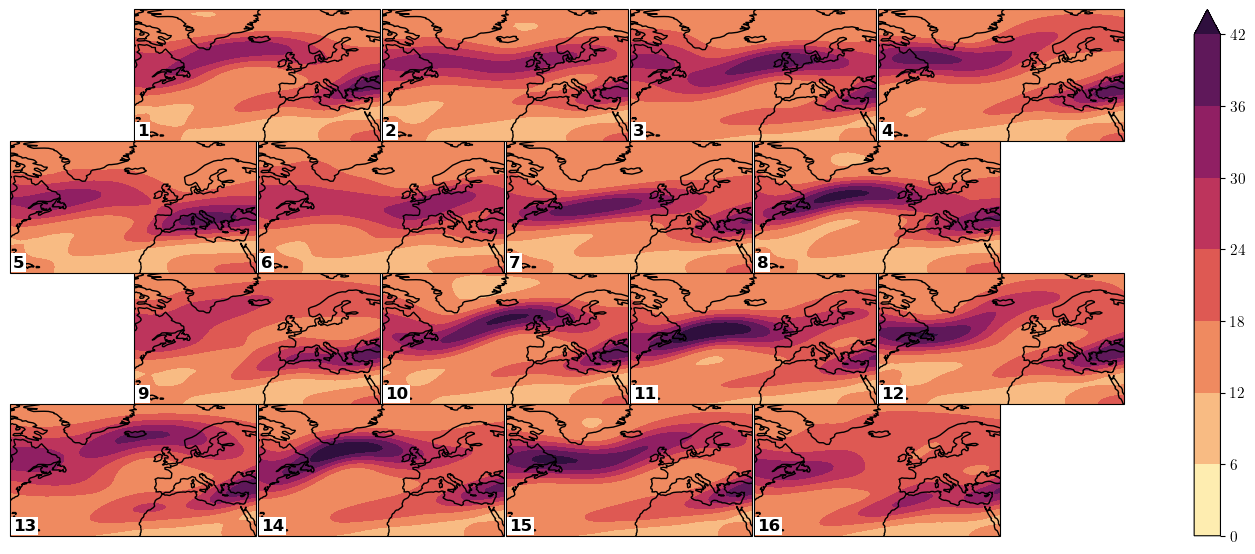

In [5]:
clu = Clusterplot(4, 4, get_region(dh.da), honeycomb=True, numbering=True)
_ = clu.add_contourf(centers_summer, cmap=colormaps.matter, levels=7)

In [6]:
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(net_summer.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.1)
spells = get_persistent_spell_times_from_som(labels_summer, dists, sigma, 12, nt_before=32, nojune=False, daily=False)

(<Figure size 500x400 with 2 Axes>, <Axes: >)

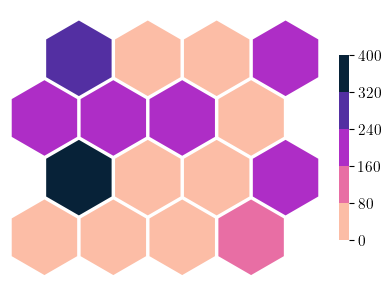

In [7]:
spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(spells_per_cluster["len"].to_numpy(), cmap=cmap, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

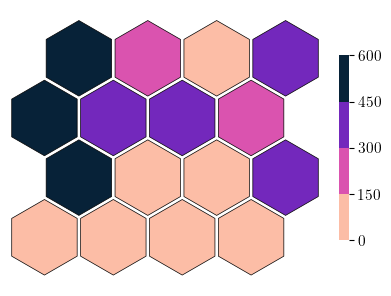

In [8]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").max())
max_len_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

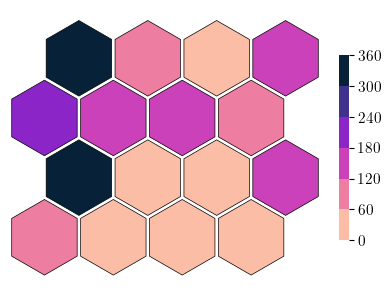

In [9]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").mean())
max_len_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

# real space composites

In [10]:
da_tp = xr.open_zarr("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/PRECL/historical/anom.zarr").rename({"member_id": "member"})
da_tp["time"] = da_tp.indexes["time"].to_datetimeindex()
da_tp = extract(da_tp, "all", None, -15, 40, 30, 75)
da_tp = da_tp.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
da_tp = compute(da_tp["tp"] * 24 * 60 * 60 * 1000, progress_flag=True)

In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


[########################################] | 100% Completed | 12.40 s


100%|██████████| 16/16 [00:01<00:00, 14.69it/s]


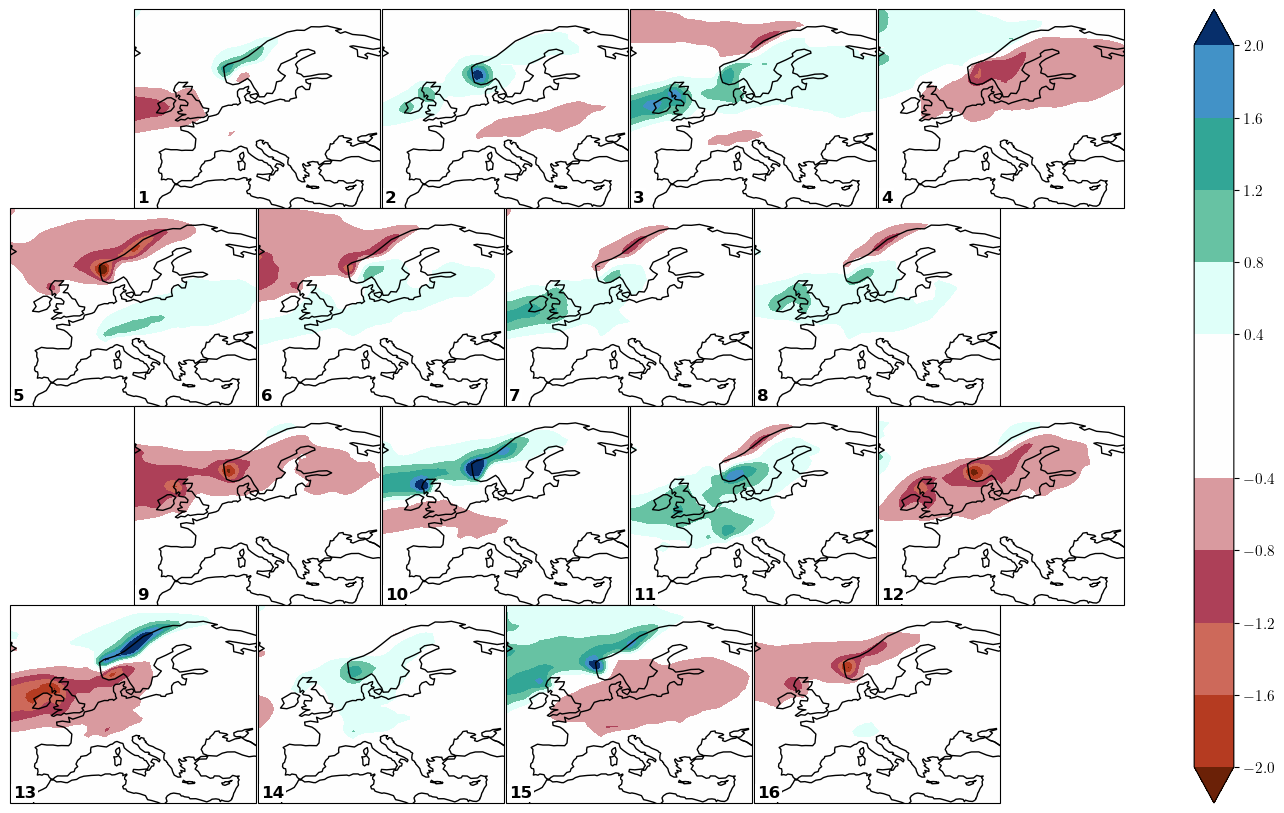

In [11]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_tp), numbering=True)
_ = clu.add_any_contour_from_mask(da_tp, mask, cmap=colormaps.precip4_diff_19lev, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
# for i in range(net.n_nodes):
#     jets = all_jets_center_summer.filter(pl.col("cluster") == i)
#     for j, jet in jets.group_by("jet ID", maintain_order=True):
#         lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
#         axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [12]:
da_T = xr.open_zarr("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/TS/historical/anom.zarr").rename({"member_id": "member"})
da_T["time"] = da_T.indexes["time"].to_datetimeindex()
da_T = extract(da_T, "all", None, -15, 40, 30, 75)
da_T = da_T.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
da_T = compute(da_T["TS"], progress_flag=True)

In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


[########################################] | 100% Completed | 11.52 s


100%|██████████| 16/16 [00:01<00:00, 14.46it/s]


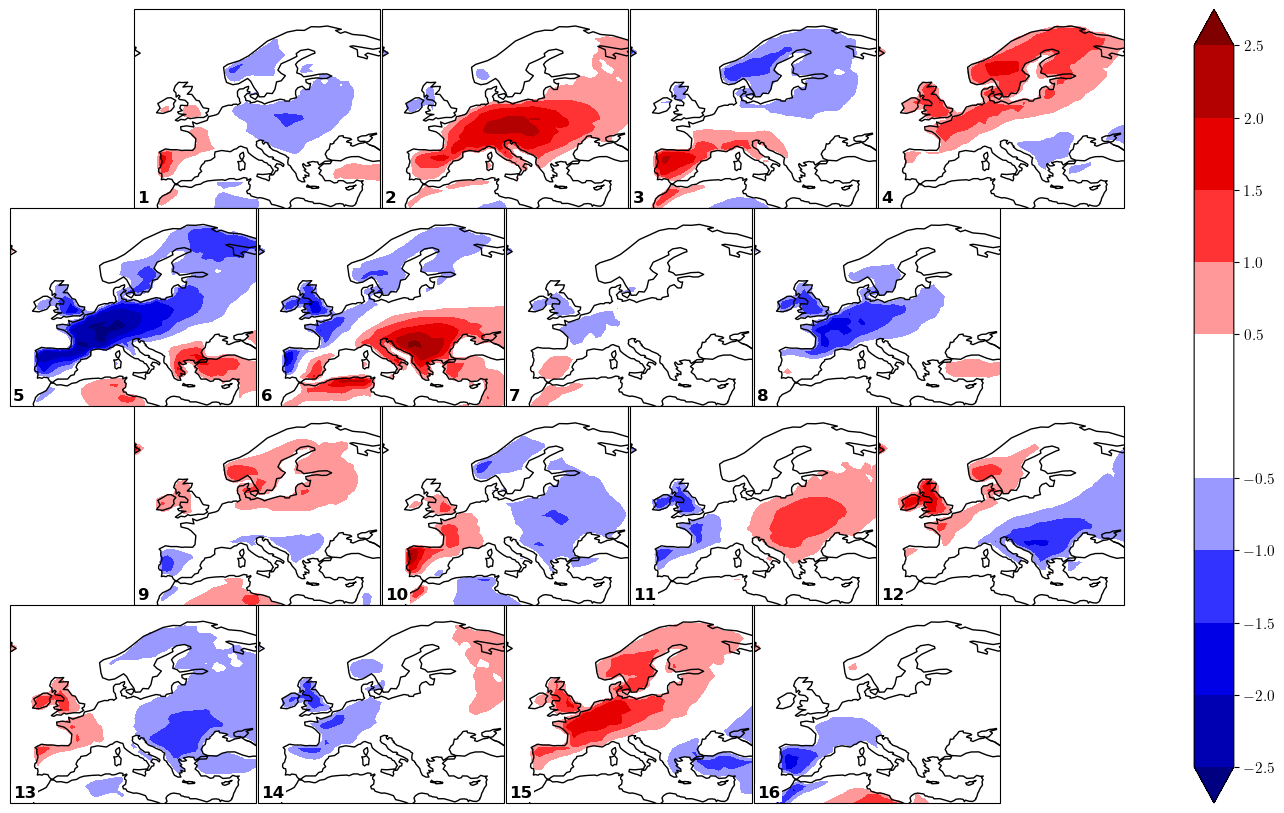

In [13]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_T), numbering=True)
_ = clu.add_any_contour_from_mask(da_T, mask, cmap=colormaps.BlWhRe, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
# for i in range(net.n_nodes):
#     jets = all_jets_center_summer.filter(pl.col("cluster") == i)
#     for j, jet in jets.group_by("jet ID", maintain_order=True):
#         lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
#         axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [2]:
from jetutils.definitions import KAPPA, RADIUS, compute
import xarray as xr
import numpy as np
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.reset_coords("time_bnds", drop=True).drop_dims("nbnd")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
ds_cesm["theta"] = (ds_cesm["t"] * (1000 / ds_cesm["lev"]) ** KAPPA).astype(np.float32)
ds_cesm = ds_cesm.drop_vars("t")
# dh = DataHandler.from_basepath_and_da("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical/results", ds_cesm)
# exp = JetFindingExperiment(dh)
# all_jets_one_df = exp.find_jets()
# props_as_df = exp.props_as_df()

In [ ]:
from jetutils.definitions import KAPPA, RADIUS, compute
import xarray as xr
ds_cesm = ds_cesm.assign_coords(
    {
        "x": np.radians(ds_cesm["lon"]) * RADIUS,
        "y": RADIUS
        * np.log(
            (1 + np.sin(np.radians(ds_cesm["lat"])) / np.cos(np.radians(ds_cesm["lat"])))
        ),
    }
)
vort1 = compute(ds_cesm["v"].differentiate("x") - ds_cesm["u"].differentiate("y"), progress_flag=True)

[########################################] | 100% Completed | 82.77 s


In [ ]:
ds_cesm["u"].metpy.units

<Unit('meter / second')>

In [91]:
np.round(vort1.lat[[0, -1]], 2)

<xarray.DataArray 'lat' (lat: 2)> Size: 8B
array([15.55, 79.63], dtype=float32)
Coordinates:
  * lat      (lat) float32 8B 15.55 79.63
    y        (lat) float32 8B 1.564e+06 1.189e+07
Attributes:
    long_name:    latitude
    units:        degrees_north
    _metpy_axis:  y,latitude

In [ ]:
lat = vort1.lat.values
dl = round(lat[1] - lat[0], 2)
newlat = np.arange(lat[0], lat[-1] + dl, dl)
vort1 = vort1.assign_coords(lat=newlat)

array([15.55   , 16.49235, 17.43471, 18.37706, 19.31941, 20.26176,
       21.20412, 22.14647, 23.08882, 24.03118, 24.97353, 25.91588,
       26.85823, 27.80059, 28.74294, 29.68529, 30.62765, 31.57   ,
       32.51235, 33.4547 , 34.39706, 35.33941, 36.28176, 37.22411,
       38.16647, 39.10882, 40.05117, 40.99353, 41.93588, 42.87823,
       43.82058, 44.76294, 45.70529, 46.64764, 47.59   , 48.53235,
       49.4747 , 50.41705, 51.35941, 52.30176, 53.24411, 54.18647,
       55.12882, 56.07117, 57.01352, 57.95588, 58.89823, 59.84058,
       60.78294, 61.72529, 62.66764, 63.60999, 64.55235, 65.4947 ,
       66.43706, 67.37941, 68.32176, 69.26411, 70.20647, 71.14882,
       72.09117, 73.03352, 73.97588, 74.91823, 75.86058, 76.80293,
       77.74529, 78.68764, 79.63   ], dtype=float32)

In [104]:
import wavebreaking 
wavebreaking.calculate_cutoffs(vort1[0])

ValueError: No regular grid found for dimension lat.

In [75]:
from metpy.units import units
np.linalg.norm(vort1 / units.seconds - vort2) / vort1.data.size

np.float64(3.141474363059356e-08)

In [44]:
vort2 = mcalc.vorticity(ds_cesm["u"].isel(time=0), ds_cesm["v"].isel(time=0)).compute()

In [ ]:
ds_cesm["v"].differentiate("lon") - ds_cesm["u"].differentiate("lat")

<xarray.DataArray (member: 49, time: 14600, lat: 69, lon: 97)> Size: 19GB
dask.array<sub, shape=(49, 14600, 69, 97), dtype=float32, chunksize=(1, 100, 69, 97), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 276B 15.55 16.49 17.43 18.38 ... 77.75 78.69 79.63
  * lon      (lon) float32 388B -80.0 -78.75 -77.5 -76.25 ... 37.5 38.75 40.0
  * member   (member) <U15 3kB 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time     (time) object 117kB 1970-01-01 12:00:00 ... 2009-12-31 12:00:00